## Predict a fraud
In this notebook, I'll work on detecting fraud with prioritizing correctly finding fraud rather than correctly labeling non-fraudulent transactions

The data is taken from here:<br>
https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
cc_df = pd.read_csv('credit_card.csv')

print("The data frame shape is:", cc_df.shape)

cc_df.head()

The data frame shape is: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# number of frauds
(cc_df['Class'] == 1).sum()

492

### About the data
The dataset presents transactions that occurred in two days in September 2013 by European cardholders.
Due to confidentiality, the features are represented as V1, V2, etc. The 'Time' feature contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' feature is the amount of the purchase. 'Class' is the dependent column; 1 means it's a fraud, 0 it's not a fraud. <br>As it can be seen, there are few frauds in the dataset, 492 out of 283807 (0.173%, very unbalanced).

In [4]:
# check for null values and type
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
# Checking into 'Time' since seems to a bit arbitrary
print(cc_df['Time'].describe())

# it has a huge std and the values continuingly increasing (time past); therefore, dropping this column 
cc_df = cc_df.drop('Time', axis=1)

cc_df.head()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


V1


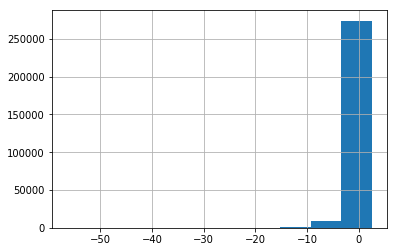

V2


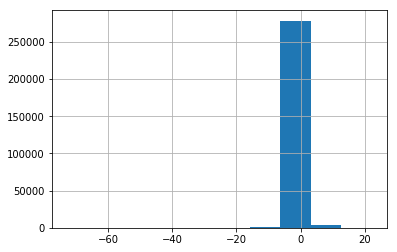

V3


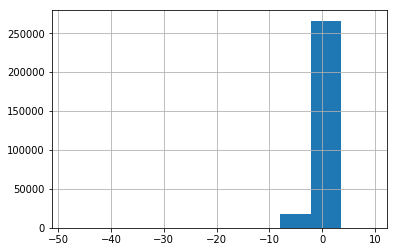

V4


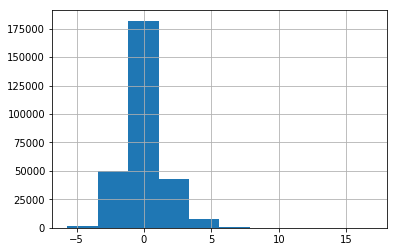

V5


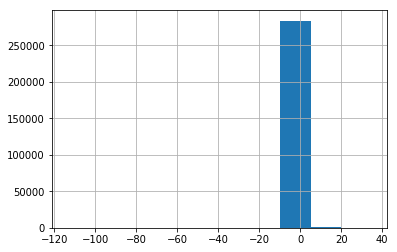

V6


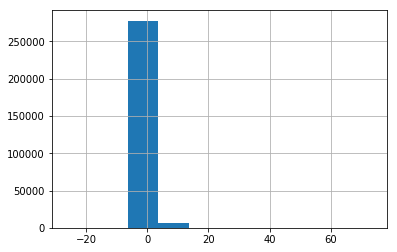

V7


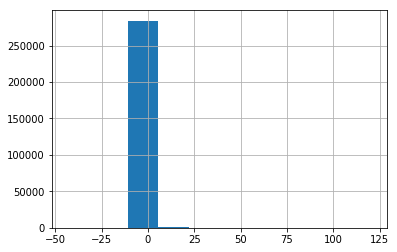

V8


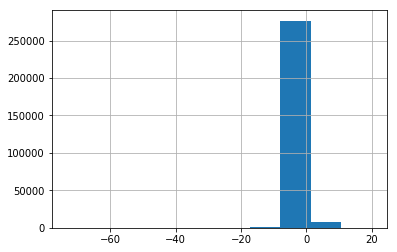

V9


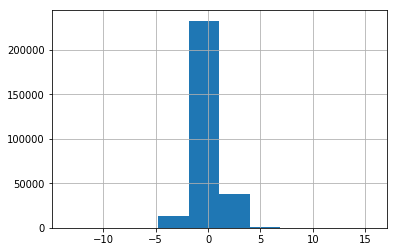

V10


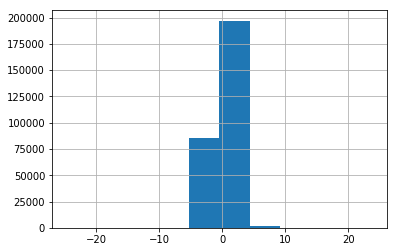

V11


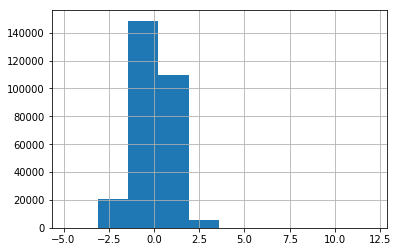

V12


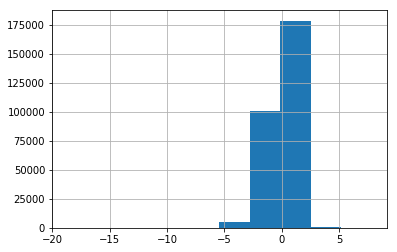

V13


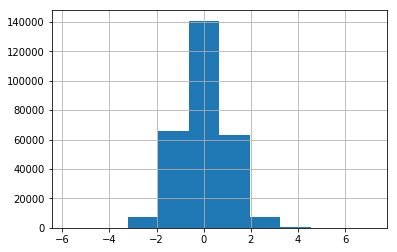

V14


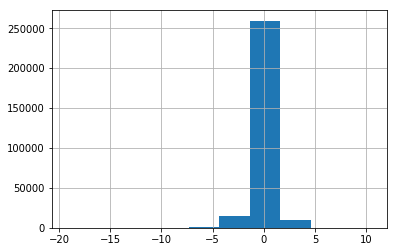

V15


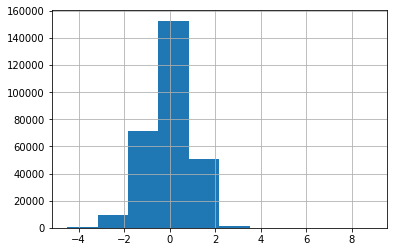

V16


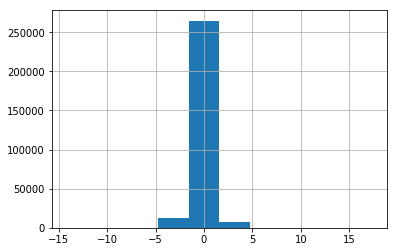

V17


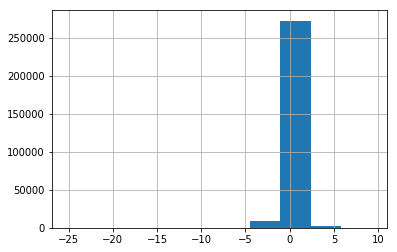

V18


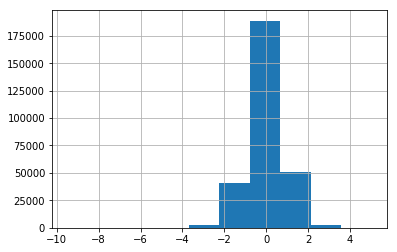

V19


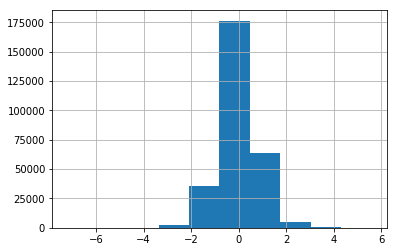

V20


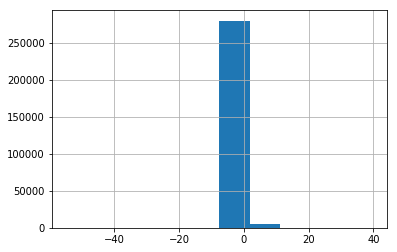

V21


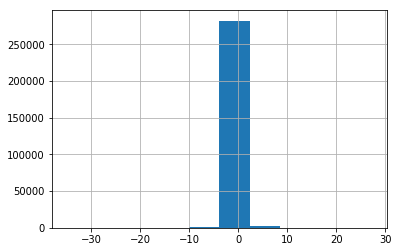

V22


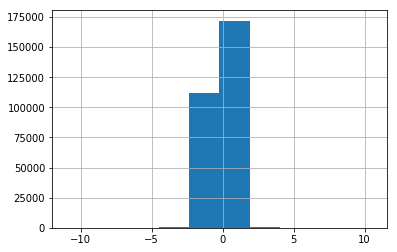

V23


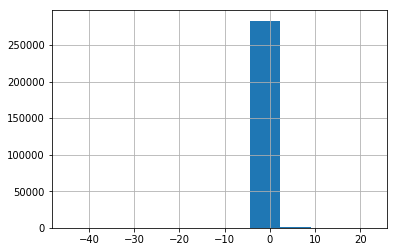

V24


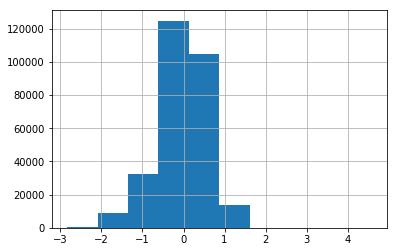

V25


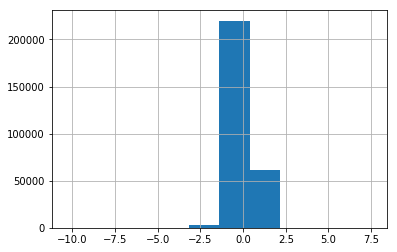

V26


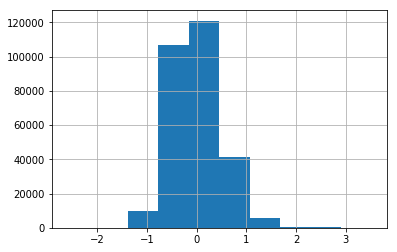

V27


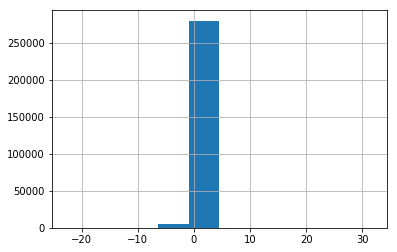

V28


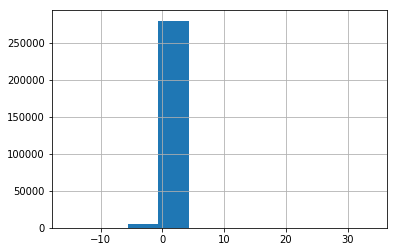

Amount


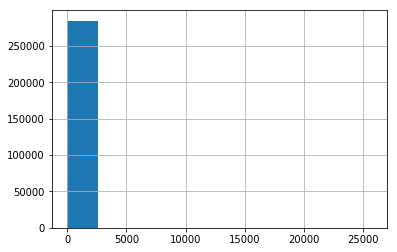

In [6]:
tmp1 = cc_df.iloc[:,:-1]

for col in tmp1.columns:
    print(col)
    tmp1[col].hist()
    plt.show()

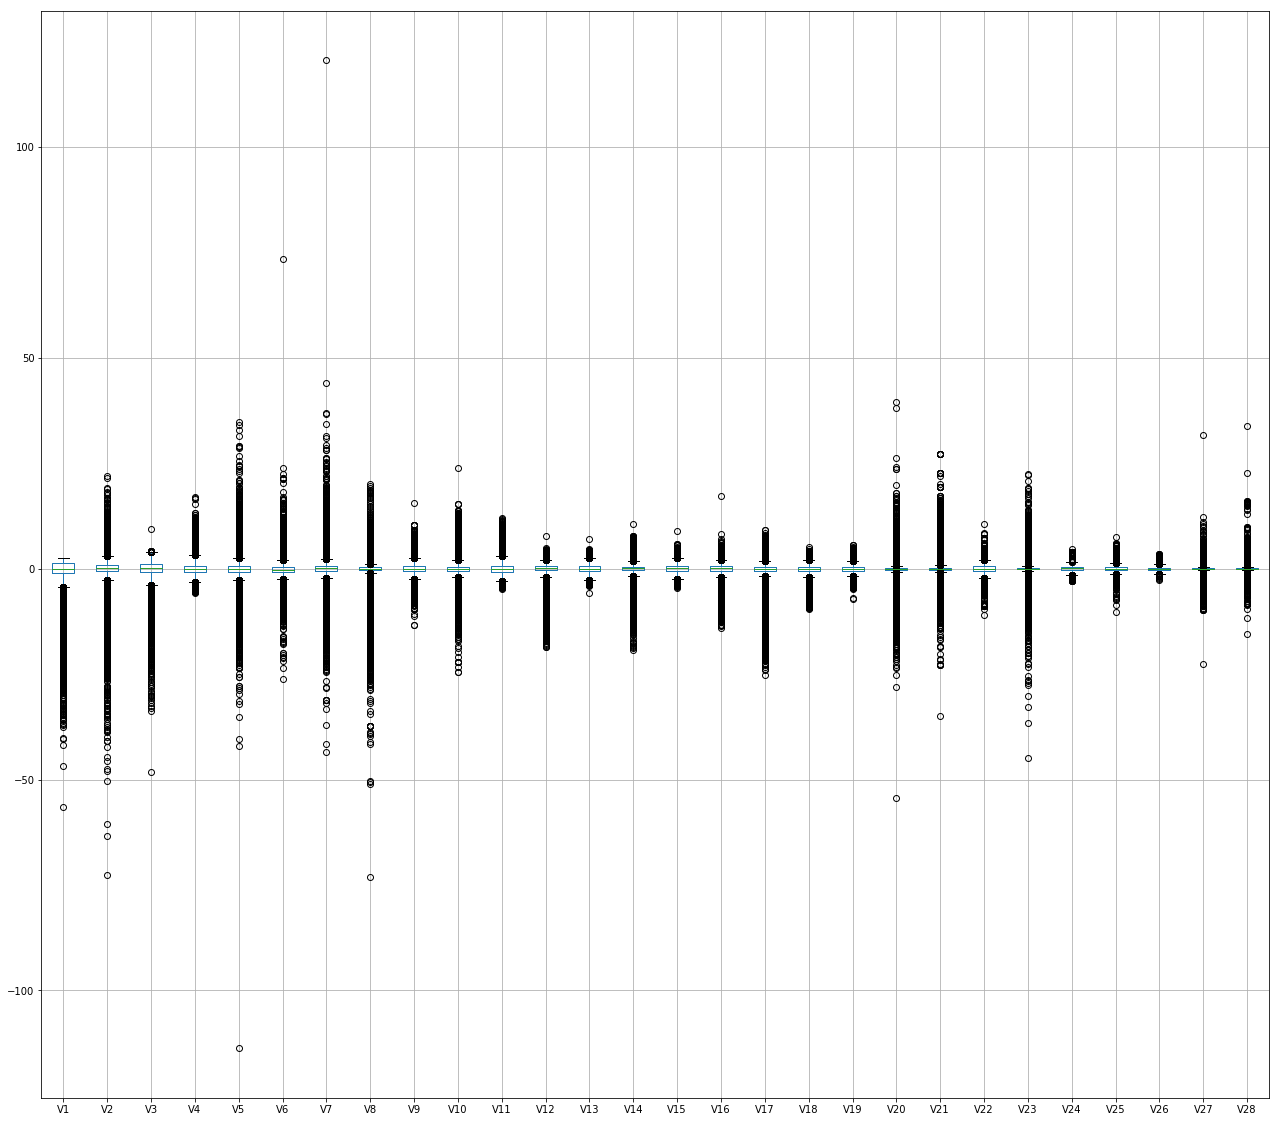

In [7]:
plt.rcParams["figure.figsize"] = (22,20)
tmp2 = cc_df.iloc[:,:-2]
fig = tmp2.boxplot()

From above, all the features have many outliers; many of them are not on the same scale, and they all tend to be in very few buckets (not evenly distributed). Furthermore, there's still a problem with the class imbalance. <br>
I'll next, oversample the fraud class and train the model. I'll do it to see how it affects the model evaluation. Then I'll address the outliers, scale the data, and then see the results model evaluation again.

Oversampling will make a copy of the minority class (fraud). To avoid overfitting, first, I'll split the data, then add it together. The reason is that we don't want to have the same exact data (copy) in the test and train samples.

In [8]:
# Separate input features and target
y = cc_df['Class']
X = cc_df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=24) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    213247
0    213247
Name: Class, dtype: int64

In [9]:
# train the model
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)

Above, The training fraud class was oversampled; so the model will be trained on equal amounts of fraud and not a fraud. The test part, however, remained untouched; so it has much fewer frauds than not frauds.

In [10]:
# Random forst
clf = RandomForestClassifier(n_estimators=10, max_depth=3)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.9936659082610039


In [11]:
# Logistic regression
lrg = LogisticRegression(solver='liblinear')
lrg.fit(X_train, y_train)

lrg.score(X_test, y_test)

0.9773601865116148

Since we decided to focus on how many right frauds the algorithm gets, I'll build a quick confusion matrix to answer this question for each model.

In [12]:
# dictionary to use for confusion matrix
tree_dict = {"TP": 0,
            "TN": 0,
            "FP": 0, 
            "FN": 0}
# rest the index of y_test to compare
pred_ser = pd.Series(clf.predict(X_test))
truth_rslt = pd.Series(y_test).reset_index(drop=True)

# add values to the dict based on their values
for i in range(len(pred_ser)):
    if(pred_ser[i] == 1 and truth_rslt[i] == 1):   # true positive
        tree_dict["TP"] += 1
    elif(pred_ser[i] == 0 and truth_rslt[i] == 0): # true negative
        tree_dict["TN"] += 1
    elif(pred_ser[i] == 1 and truth_rslt[i] == 0): # false positive
        tree_dict["FP"] += 1
    else:                                          # flase negative
        tree_dict["FN"] += 1
        
tree_dict

{'TP': 109, 'TN': 70642, 'FP': 426, 'FN': 25}

In [13]:
# dictionary to use for confusion matrix
log_dict = {"TP": 0,
            "TN": 0,
            "FP": 0, 
            "FN": 0}
# rest the index of y_test to compare
pred_ser = pd.Series(lrg.predict(X_test))
truth_rslt = pd.Series(y_test).reset_index(drop=True)

# add values to the dict based on their values
for i in range(len(pred_ser)):
    if(pred_ser[i] == 1 and truth_rslt[i] == 1):   # true positive
        log_dict["TP"] += 1
    elif(pred_ser[i] == 0 and truth_rslt[i] == 0): # true negative
        log_dict["TN"] += 1
    elif(pred_ser[i] == 1 and truth_rslt[i] == 0): # false positive
        log_dict["FP"] += 1
    else:                                          # flase negative
        log_dict["FN"] += 1
        
log_dict

{'TP': 111, 'TN': 69479, 'FP': 1589, 'FN': 23}

After seeing these results, I'll scale the data and see how the models can classify the data then.

In [14]:
# scale the data 
# since I don't know what the features really are, and many of them have negative value; the scale is -1 to 1
scaler = MinMaxScaler(feature_range=(-1,1))
df_scaled = cc_df
X_scaled = df_scaled.iloc[:, :-1]
X_scaled = pd.DataFrame(scaler.fit_transform(X_scaled), columns=X_scaled.columns)

X_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.870385,0.532981,0.762730,-0.373955,0.526877,-0.464663,-0.466370,0.572888,-0.049377,0.021201,...,0.165884,0.122369,0.045984,0.327586,-0.217495,0.170244,-0.210886,-0.162048,-0.374607,-0.988352
1,0.957084,0.540133,0.680597,-0.456407,0.532241,-0.475617,-0.470249,0.572597,-0.092038,0.010535,...,0.159060,0.115680,-0.039526,0.333876,-0.327120,0.174581,-0.107974,-0.167310,-0.373155,-0.999791
2,0.870434,0.506235,0.736282,-0.462469,0.524658,-0.437756,-0.459646,0.576085,-0.178795,0.026036,...,0.171710,0.130955,0.092060,0.357878,-0.421292,0.119030,-0.194546,-0.169021,-0.376177,-0.970522
3,0.883756,0.530608,0.736967,-0.572678,0.531294,-0.448882,-0.466394,0.578868,-0.170001,0.015170,...,0.156100,0.119467,0.020554,0.325214,-0.552348,0.228491,-0.221607,-0.164663,-0.371258,-0.990386
4,0.877234,0.553040,0.728501,-0.460407,0.525950,-0.472032,-0.462064,0.564967,-0.018101,0.048606,...,0.169231,0.122655,0.094541,0.326784,-0.197460,0.132685,0.014994,-0.158878,-0.365020,-0.994551


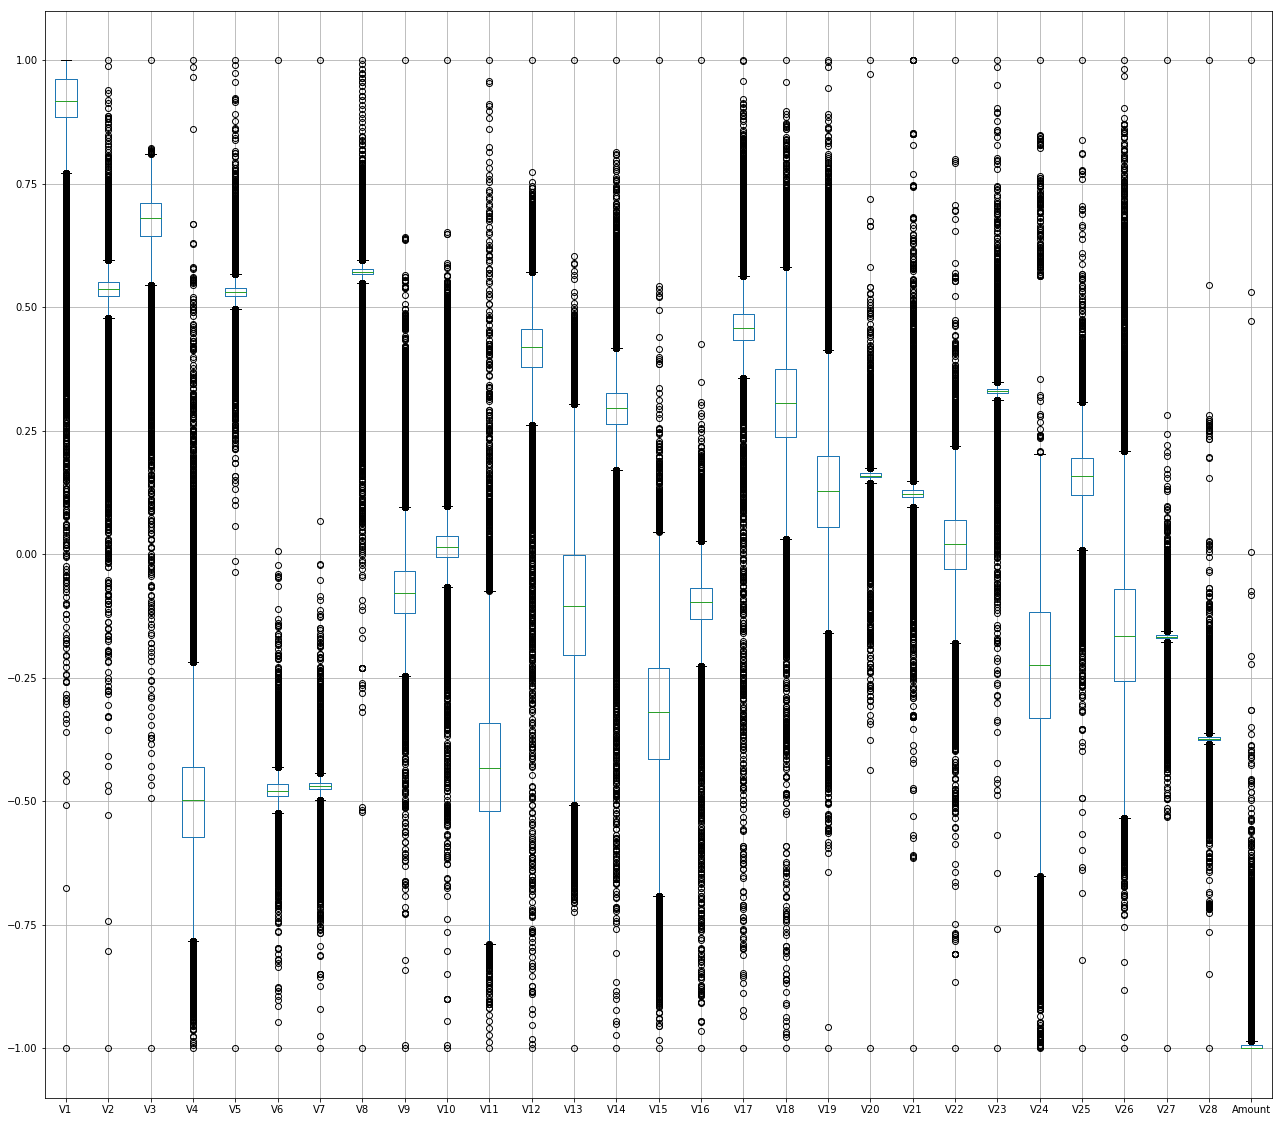

In [15]:
X_scaled.boxplot()

The graph above is a bit overwhelming, but it's to show that all the features have many outliers. 
The outliers cannot be dropped because we might lose all the data; one way might be to replace them with the average value of that feature.

In [16]:
# Separate input features and target
y = df_scaled['Class']
X = df_scaled.drop('Class', axis=1)

In [17]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=24) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    213247
0    213247
Name: Class, dtype: int64

In [18]:
# train the model
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)


In [19]:
# Random forst
clf = RandomForestClassifier(n_estimators=10, max_depth=3)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.9941293783882476


In [20]:
# dictionary to use for confusion matrix
tree_dict = {"TP": 0,
            "TN": 0,
            "FP": 0, 
            "FN": 0}
# rest the index of y_test to compare
pred_ser = pd.Series(clf.predict(X_test))
truth_rslt = pd.Series(y_test).reset_index(drop=True)

# add values to the dict based on their values
for i in range(len(pred_ser)):
    if(pred_ser[i] == 1 and truth_rslt[i] == 1):   # true positive
        tree_dict["TP"] += 1
    elif(pred_ser[i] == 0 and truth_rslt[i] == 0): # true negative
        tree_dict["TN"] += 1
    elif(pred_ser[i] == 1 and truth_rslt[i] == 0): # false positive
        tree_dict["FP"] += 1
    else:                                          # flase negative
        tree_dict["FN"] += 1
        
tree_dict

{'TP': 109, 'TN': 70675, 'FP': 393, 'FN': 25}

In [21]:
# Logistic regression
lrg = LogisticRegression(solver='liblinear')
lrg.fit(X_train, y_train)

lrg.score(X_test, y_test)

0.9773601865116148

In [22]:
# dictionary to use for confusion matrix
log_dict = {"TP": 0,
            "TN": 0,
            "FP": 0, 
            "FN": 0}
# rest the index of y_test to compare
pred_ser = pd.Series(lrg.predict(X_test))
truth_rslt = pd.Series(y_test).reset_index(drop=True)

# add values to the dict based on their values
for i in range(len(pred_ser)):
    if(pred_ser[i] == 1 and truth_rslt[i] == 1):   # true positive
        log_dict["TP"] += 1
    elif(pred_ser[i] == 0 and truth_rslt[i] == 0): # true negative
        log_dict["TN"] += 1
    elif(pred_ser[i] == 1 and truth_rslt[i] == 0): # false positive
        log_dict["FP"] += 1
    else:                                          # flase negative
        log_dict["FN"] += 1
        
log_dict

{'TP': 111, 'TN': 69479, 'FP': 1589, 'FN': 23}